In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

In [55]:
df = pd.read_csv("Pizza_Sales.csv")

## EDA

In [56]:
df.dtypes

order_details_id              int64
order_id                      int64
pizza_id                     object
quantity                      int64
order_date           datetime64[ns]
order_time                   object
unit_price                  float64
total_price                 float64
pizza_size                   object
pizza_category               object
pizza_ingredients            object
pizza_name                   object
dtype: object

In [57]:
df.shape

(48620, 12)

In [58]:
df.isnull().sum()

order_details_id     0
order_id             0
pizza_id             0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [59]:
df.sample(2)

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
45982,45983,20184,cali_ckn_m,1,2015-12-09,17:42:21,16.75,16.75,M,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ...",The California Chicken Pizza
42253,42254,18586,four_cheese_l,1,2015-11-13,16:54:22,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza


### Data Modification

In [60]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_time']=df['order_time'].astype('string')

#### Adding column to identify whether particular day is a holiday or not

In [61]:
holiday_list = holidays.USA(years=[2015])
range_of_date = df['order_date'].dt.date.to_list()
df['is_holiday'] = [date in holiday_list.keys() for date in range_of_date]

#### Adding columns like dayofweek , pizza_size_type,hour, etc  for future processing

In [62]:
days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

#hour
df[['Hour','Minute', 'Second']]= df['order_time'].str.split(":",expand=True)

# month
df['month'] = df['order_date'].dt.month_name()
# days of the week
df['dayOfWeek'] = df['order_date'].dt.dayofweek
df['dayOfWeek'] = df['dayOfWeek'].apply(lambda x: days[x])

# pizza_size_type
df['pizza_size_type'] = df['pizza_size'] + "_" + df['pizza_category']

#veg or non veg
df['veg_nonveg']= df['pizza_ingredients'].str.contains('Chicken|Sausage|Pepperoni|Ham|Bacon', regex=True)
df['veg_nonveg']= np.where(df["veg_nonveg"] == True, 'nonveg', 'veg')


In [63]:
df.sample(2)

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,is_holiday,Hour,Minute,Second,month,dayOfWeek,pizza_size_type,veg_nonveg
23448,23449,10307,green_garden_l,1,2015-06-22,18:02:36,20.25,20.25,L,Veggie,"Spinach, Mushrooms, Tomatoes, Green Olives, Fe...",The Green Garden Pizza,False,18,02,36,June,Monday,L_Veggie,veg
6494,6495,2876,sicilian_l,1,2015-02-17,19:46:45,20.25,20.25,L,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",The Sicilian Pizza,False,19,46,45,February,Tuesday,L_Supreme,nonveg


## Findings

### 1. Finding Which pizza types sell the most

In [64]:
pizza_sales = df['pizza_name'].value_counts()
most_sold_pizza = pizza_sales.head(1)

In [65]:
print("{} with the {} counts is the mostly ordered pizza".format(most_sold_pizza.index[0],most_sold_pizza[0]))

The Classic Deluxe Pizza with the 2416 counts is the mostly ordered pizza


In [66]:
#three most ordered pizza by name
pizza_sales.head(3)

The Classic Deluxe Pizza      2416
The Barbecue Chicken Pizza    2372
The Hawaiian Pizza            2370
Name: pizza_name, dtype: int64

### 2. Which ingredients are in demand?

In [67]:
#splitting pizza ingredients columns by comma and caluculating their use 
ingredients_count=df['pizza_ingredients'].str.split(',').explode().value_counts()

#### Top 10 Ingredients

In [68]:
top_10 = ingredients_count.head(10)

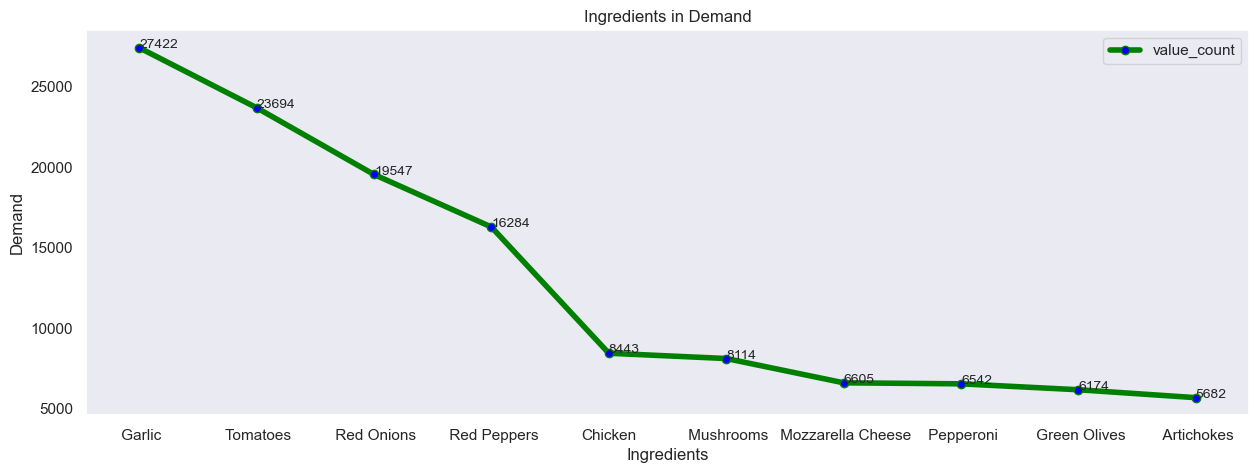

In [69]:
fig, ax = plt.subplots(figsize=(15,5))

# Top 10
ingredients = np.array(top_10.index)
demand = np.array(top_10)
# fetching data points for each marker point
for index in range(len(ingredients)):
    ax.text(ingredients[index], demand[index], demand[index], size=10)
    
plt.plot(ingredients,demand,marker='o', markerfacecolor='blue',markersize=6, color='green', linewidth=4,label="value_count")

plt.xlabel("Ingredients")
plt.ylabel("Demand")
plt.legend()
plt.title("Ingredients in Demand")
plt.show();

### 3. Are there more (or less) sales of a certain type of pizza in a certain month, or day, or time of the day?

#### Certain Month

In [70]:
df_pizza_orders_month  = df.groupby(['month','pizza_name']).agg(pizza_sold=('order_details_id','count')).sort_values(by=['month']).reset_index()

# sorting based on month
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_pizza_orders_month['month'] = pd.Categorical(df_pizza_orders_month['month'], categories=new_order, ordered=True)
df_pizza_orders_month = df_pizza_orders_month.sort_values(by=['month']).reset_index(drop=True)


In [71]:
max_sold = df_pizza_orders_month[df_pizza_orders_month['pizza_sold'] == df_pizza_orders_month.pizza_sold.max()]
min_sold = df_pizza_orders_month[df_pizza_orders_month['pizza_sold'] == df_pizza_orders_month.pizza_sold.min()]

pizza_sold_by_month = pd.concat([max_sold,min_sold])

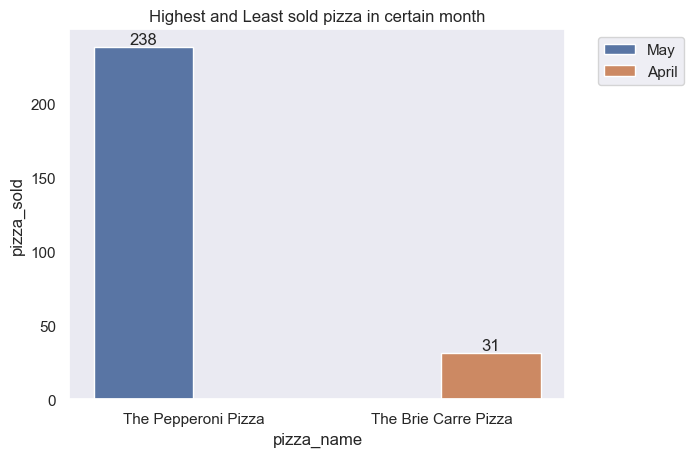

In [72]:
ax = sns.barplot(data=pizza_sold_by_month, x="pizza_name", y="pizza_sold",hue=['May','April'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1), ncol=1, title_fontsize=14);
for container in ax.containers:
    ax.bar_label(container)
plt.title("Highest and Least sold pizza in certain month")
plt.show();

#### Certain day of the week

In [73]:
df_pizza_orders_day  = df.groupby(['dayOfWeek','pizza_name']).agg(pizza_sold=('order_details_id','count')).sort_values(by=['dayOfWeek']).reset_index()
df_pizza_orders_day = df_pizza_orders_day.sort_values(by=['dayOfWeek']).reset_index(drop=True)


In [74]:
max_sold = df_pizza_orders_day[df_pizza_orders_day['pizza_sold'] == df_pizza_orders_day.pizza_sold.max()]
min_sold = df_pizza_orders_day[df_pizza_orders_day['pizza_sold'] == df_pizza_orders_day.pizza_sold.min()]
df_pizza_orders_day = pd.concat([max_sold,min_sold])

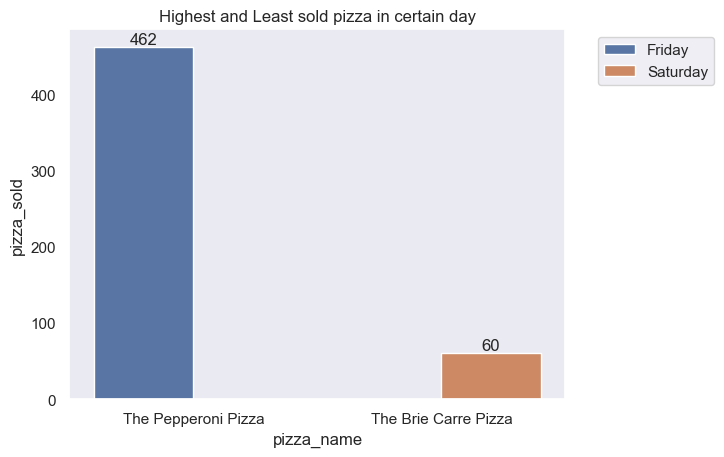

In [75]:
ax = sns.barplot(data=df_pizza_orders_day, x="pizza_name", y="pizza_sold",hue=['Friday','Saturday'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1), ncol=1, title_fontsize=14);
for container in ax.containers:
    ax.bar_label(container)
plt.title("Highest and Least sold pizza in certain day")
plt.show();

#### Certain Hour

In [76]:
df_pizza_orders_hour  = df.groupby(['Hour','pizza_name']).agg(pizza_sold=('order_details_id','count')).sort_values(by=['Hour']).reset_index()
df_pizza_orders_hour = df_pizza_orders_hour.sort_values(by=['Hour']).reset_index(drop=True)


In [77]:
min_sold = df_pizza_orders_hour[df_pizza_orders_hour['pizza_sold'] == df_pizza_orders_hour.pizza_sold.min()]
min_sold['name_hour'] = min_sold['pizza_name'] + "_" + min_sold['Hour']


C:\Users\pande\AppData\Local\Temp\ipykernel_812\3636029292.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_sold['name_hour'] = min_sold['pizza_name'] + "_" + min_sold['Hour']


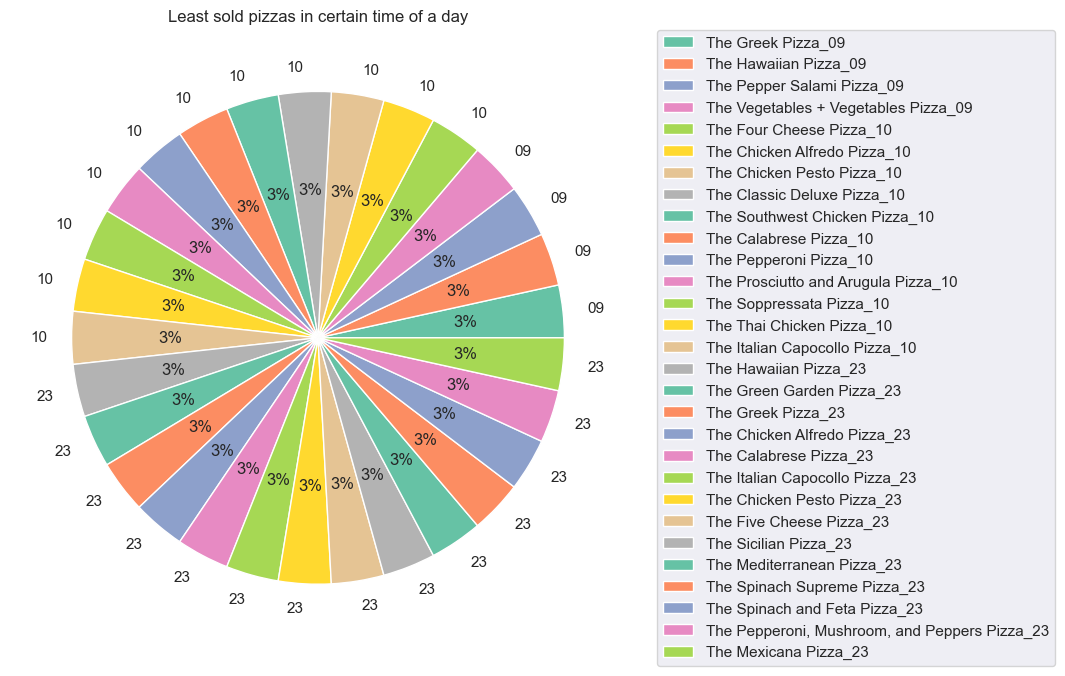

In [78]:
pizza_sold = min_sold.pizza_sold.to_list()
labels = min_sold.Hour.to_list()
legend = min_sold.name_hour.to_list()
fig, ax = plt.subplots(figsize = (8, 8))

#define Seaborn color palette to use
colors = sns.color_palette('Set2')
plt.pie(pizza_sold, labels = labels, colors = colors,autopct='%.0f%%')
ax.legend(legend,bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0)
plt.title("Least sold pizzas in certain time of a day")
plt.show();

### 4. Which pizza sizes are sold more often with which type  and ingredients ?

In [79]:

df_pizza_analysis = df.groupby(["pizza_size_type",'pizza_ingredients']).agg(pizza_sold=('order_details_id','count'))\
            .reset_index().sort_values(by=['pizza_sold'],ascending=False).reset_index(drop=True)

df_pizza_analysis['rank'] = df_pizza_analysis.groupby('pizza_size_type')['pizza_sold']\
                        .rank(method='dense',ascending=False)

df_pizza_analysis.sort_values(by=['pizza_sold'],ascending=False,inplace=True)


In [80]:
df_pizza_analysis = df_pizza_analysis[df_pizza_analysis['rank']==1.0]

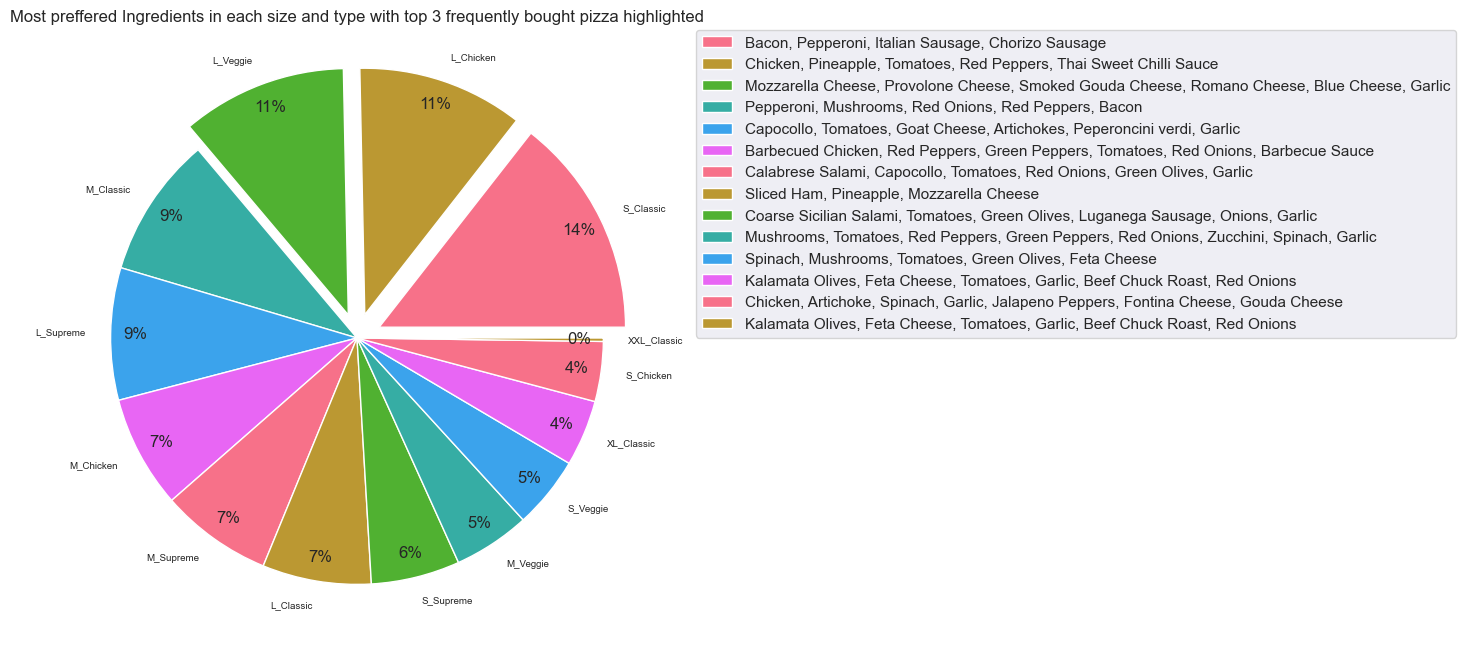

In [81]:
# defining data
highest_sold = df_pizza_analysis['pizza_sold'].to_list()
highest_sold_pizza_size_type = df_pizza_analysis['pizza_size_type'].to_list()
highest_sold_ingredients = df_pizza_analysis['pizza_ingredients'].to_list()

# declaring exploding pie
explode = [0.1, 0.1, 0.1, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0]

#define Seaborn color palette to use
colors = sns.color_palette('husl')


fig, ax = plt.subplots(figsize = (8, 8))

patches, texts, autotexts  = plt.pie(highest_sold, labels = highest_sold_pizza_size_type, explode = explode, colors = colors,pctdistance=0.9,autopct='%.0f%%')

# reducing the fontsize of the labels
[ _.set_fontsize(7) for _ in texts ]
ax.legend(highest_sold_ingredients,bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0)
plt.title("Most preffered Ingredients in each size and type with top 3 frequently bought pizza highlighted")
plt.show();

### 5. Is there a time of the day when there is a peak sale in a week? 

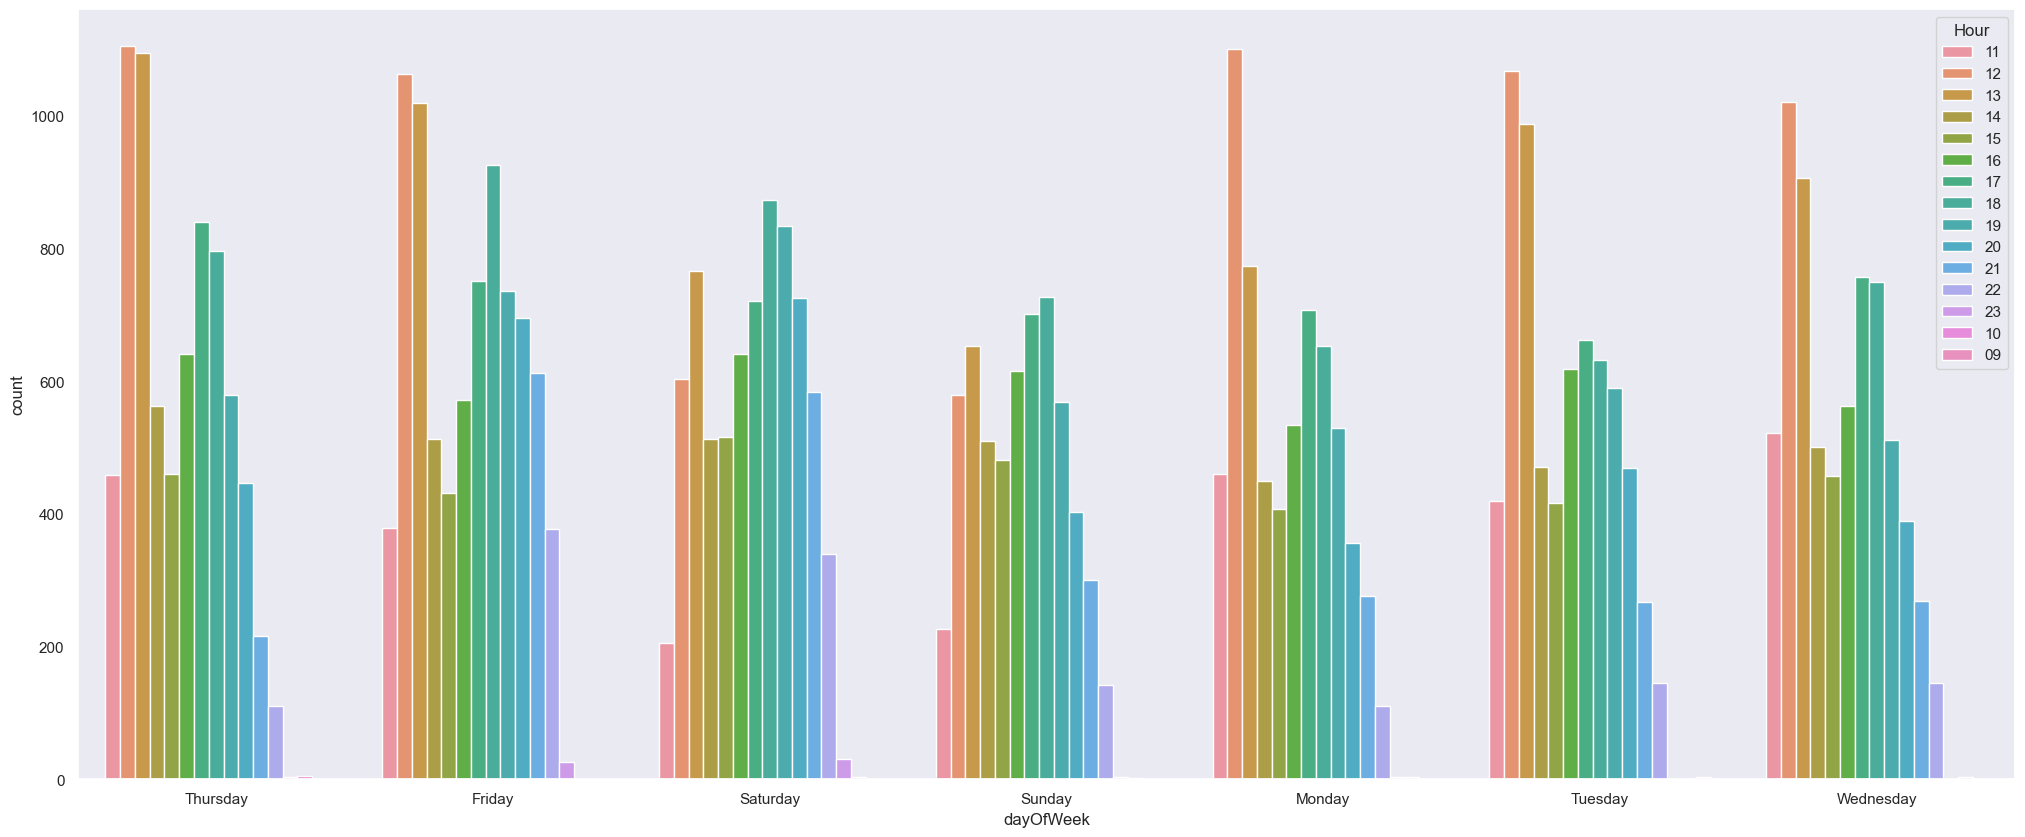

In [82]:
plt.figure(figsize = (25,10))
sns.set_theme(style="dark")
ax = sns.countplot(x = 'dayOfWeek',hue = 'Hour',data = df)

### From the above plot, it is clear that 12:00 PM and 1:00 PM has majority of the orders in the weekdays. Over a weekend 4:00 - 5:00 PM orders crossed 12:00 - 1:00 PM orders

### 6.  Pizza sales during Public Holidays

In [83]:
df_holidays = df[df['is_holiday'] == True]

In [84]:
df_holidays_grouped = df_holidays.groupby("order_date").agg(pizza_sale=('order_details_id','count'))\
            .reset_index().sort_values(by=['pizza_sale'],ascending=False)
df_holidays_grouped['holiday'] = [holiday_list[date] for date in df_holidays_grouped['order_date']]

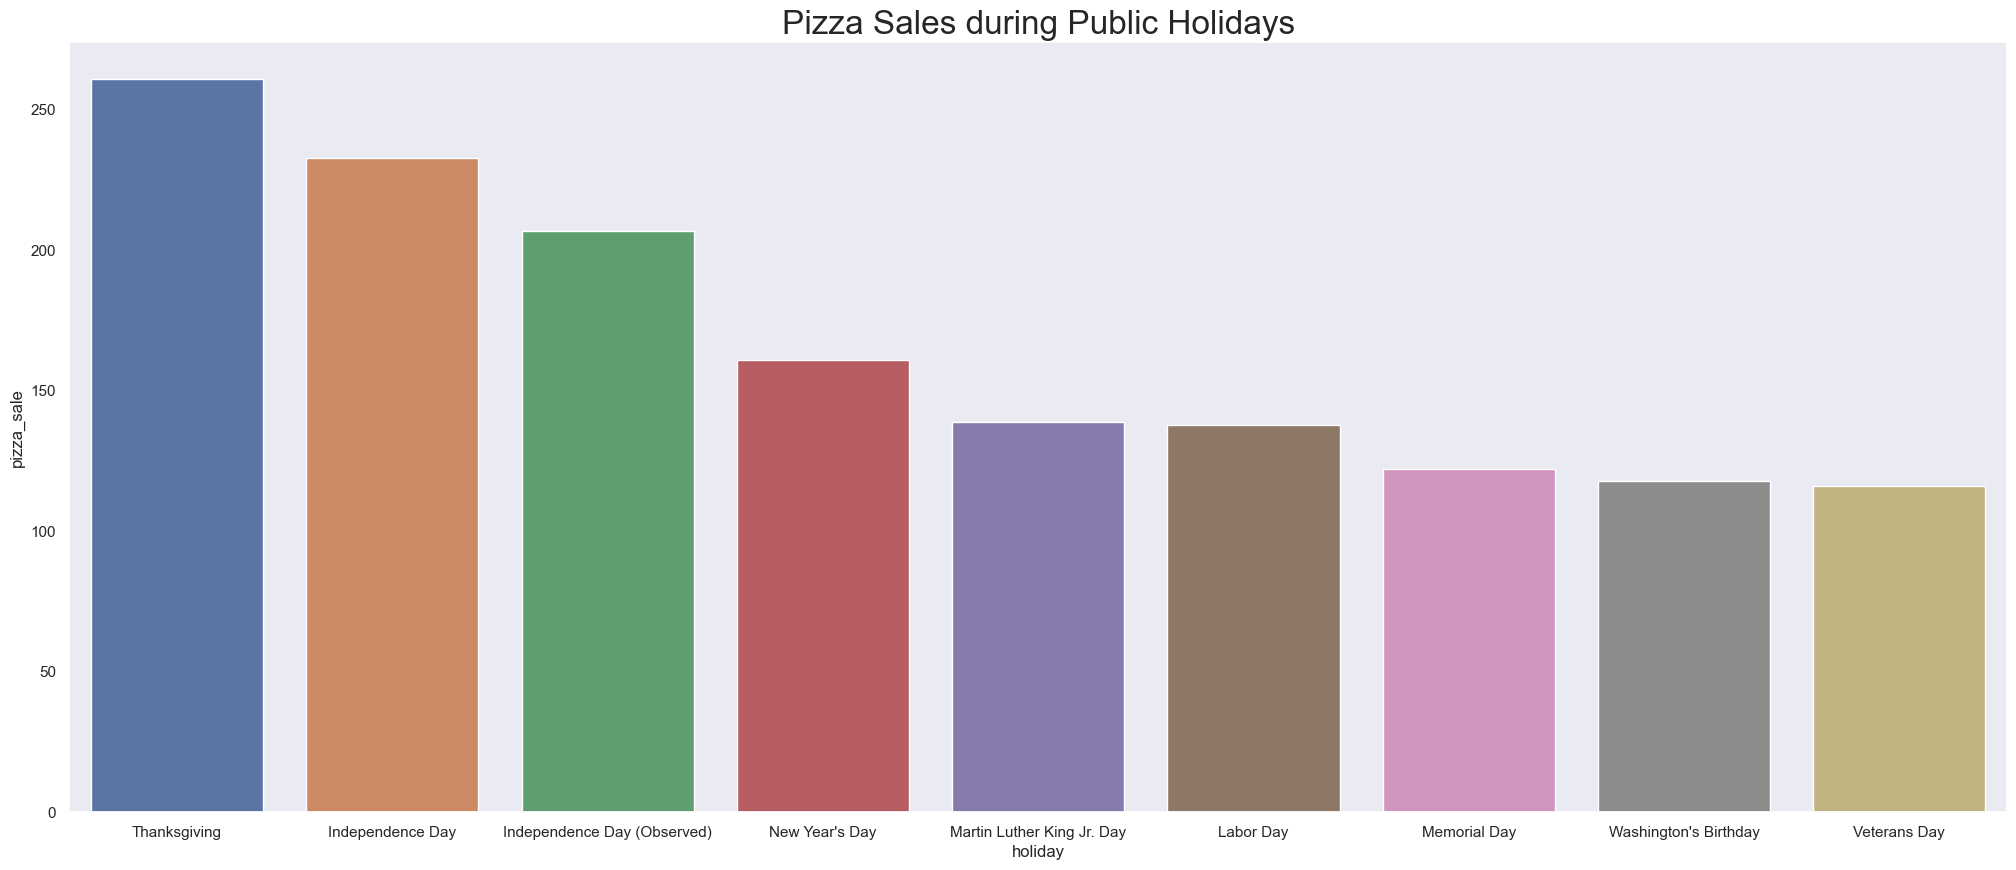

In [85]:
plt.figure(figsize = (25,10))
sns.set_theme(style="dark")
sns.barplot(data=df_holidays_grouped, x="holiday", y="pizza_sale")
plt.title("Pizza Sales during Public Holidays",fontsize=24)
plt.show();

### 7 .which is most ordered veg or non- veg and its revenue

In [86]:
pizza_sales = df['veg_nonveg'].value_counts()

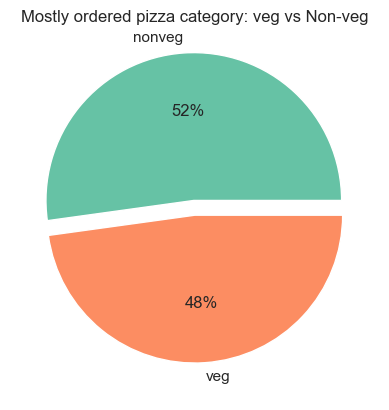

In [87]:
# plotting the graph 
colors = sns.color_palette('Set2')
explode = [0.1,0]
plt.pie(pizza_sales.values,labels=pizza_sales.index,colors=colors,explode=explode,autopct='%.0f%%')
plt.title("Mostly ordered pizza category: veg vs Non-veg")

plt.show() 

In [88]:
df_price= df.groupby(['veg_nonveg'])['total_price'].sum().reset_index()
df_price

,veg_nonveg,total_price
0,nonveg,410084.75
1,veg,407775.30


### 8.Calculating orders on specific shift of day

In [89]:
df['hour'] = df['Hour'].astype(str).astype(int)
df['ordered_shift'] = np.where((df['hour'] >= 6) & (df['hour']<11), 'morning',
                        np.where((df['hour'] >= 11) & (df['hour']<15), 'noon',
                               np.where((df['hour'] >= 15) & (df['hour']<18),'afternoon','evening')))

In [90]:
#total orders placed on different category of pizza on different shift of day
df_pizza_order_shift  = df[['pizza_category','ordered_shift']].value_counts().sort_values(ascending = False).reset_index(name = "orders")


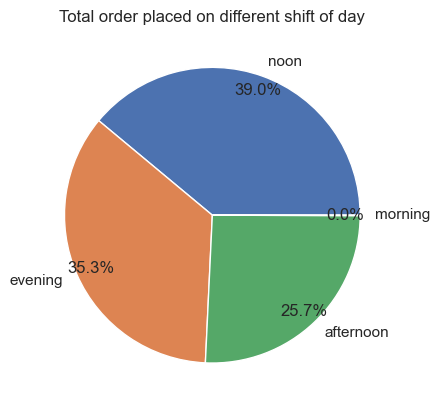

In [91]:

x = df['ordered_shift'].value_counts().index
y =df['ordered_shift'].value_counts().values
plt.pie(y,labels=x, pctdistance=0.9,autopct = '%1.1f%%')
plt.title("Total order placed on different shift of day")
fig =  plt.gcf()
plt.show()

### 9.Calculating total price of each pizza_category sold in 2015

In [92]:
df_type_price= df.groupby(['pizza_category'])['total_price'].sum().reset_index()

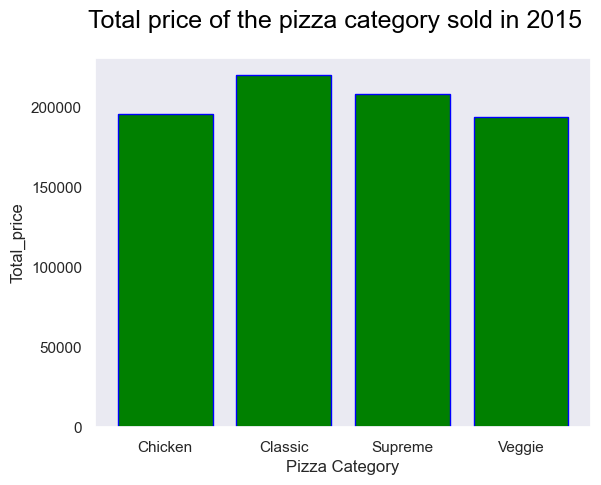

In [93]:
#assigning the column values pizza_category and total_price to the variables X and Y
x=df_type_price['pizza_category']
y=df_type_price['total_price']
plt.suptitle('Total price of the pizza category sold in 2015', fontsize=18, color='black')
plt.bar(x,y, color='green',edgecolor='blue')
plt.xlabel('Pizza Category')
plt.ylabel('Total_price');

### 10.calculating total price of the pizza sold during each day of the week in 2015 and plotting using different graphs

In [94]:
df_daywise_price= df.groupby(['dayOfWeek'])['total_price'].sum().reset_index()

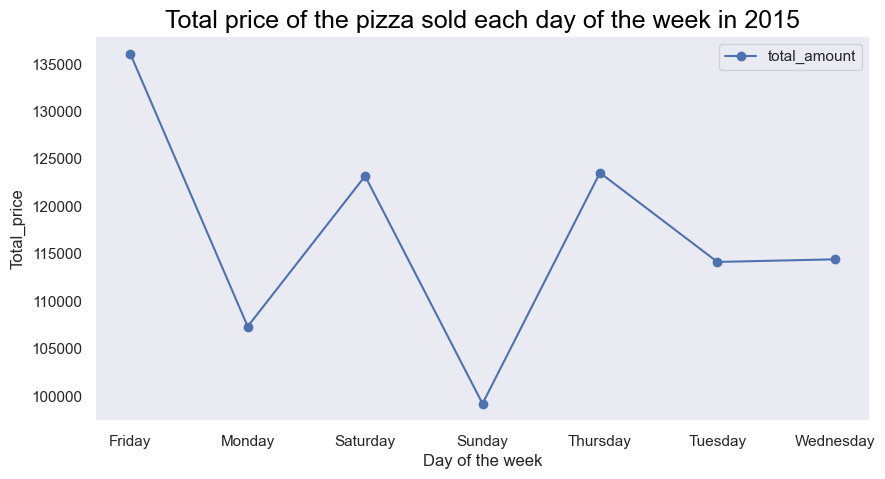

In [95]:

plt.figure(figsize=(10,5))
#assigning the column values dayOfWeek and total_price to the variables X and Y
x=df_daywise_price['dayOfWeek']
y=df_daywise_price['total_price']

plt.plot(x,y,marker='o',label="total_amount")
plt.xlabel('Day of the week')
plt.legend()
plt.ylabel('Total_price')
plt.title('Total price of the pizza sold each day of the week in 2015', fontsize=18, color='black');

### 11. Highest ordering pizza category and its top 3 ordering days


In [96]:
df_pizza  = df[['pizza_category']].value_counts().sort_values(ascending = False).reset_index(name = "orders")


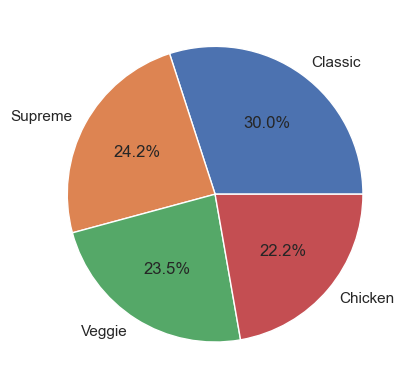

In [97]:
plt.pie(df_pizza.orders,labels=df_pizza.pizza_category,autopct = '%1.1f%%');

In [98]:
df_pizza_category  = df[['pizza_category','dayOfWeek']].value_counts().sort_values(ascending = False).reset_index(name = "orders")


In [108]:

# calculating the rank from pizza sold each day on different categories
df_pizza_category['rank'] = df_pizza_category.groupby(['pizza_category'])['orders']\
                        .rank(method='max',ascending=False)
df_pizza_category.sort_values(by=['orders','pizza_category'],ascending=False,inplace=True)

# based on the rank filtering rank 1 which shows frequently sold for each category and fetching the top 10
orders_on_pizza_category = df_pizza_category[df_pizza_category['rank'] == 1.0]
top_pizza_category = orders_on_pizza_category.set_index('pizza_category').to_dict()['dayOfWeek']


In [109]:
top_pizza_category_id = [key for key, value in top_pizza_category.items()]
# fetching the data 
top_pizza_category = df_pizza_category[\
        df_pizza_category['pizza_category'].isin(top_pizza_category_id)\
        & df_pizza_category['rank'].isin([1.0,2.0,3.0]) ]

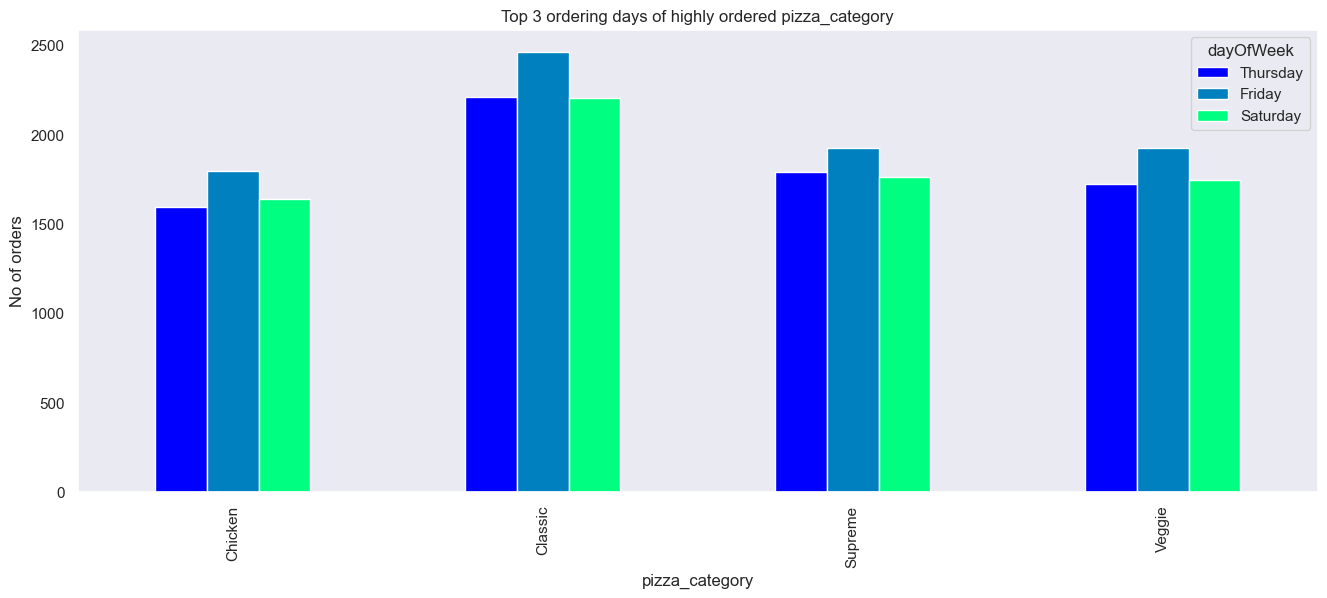

In [110]:
# transforming the data wide format to plot the comparative graph
# where each row is a pizza_category and columns are ordered days
df_plot = top_pizza_category.pivot(index=["pizza_category"], columns="dayOfWeek", values="orders").reset_index()
df_plot.plot(x="pizza_category", y=['Thursday','Friday','Saturday'], kind="bar",figsize=(16,6),title = "Top 3 ordering days of highly ordered pizza_category",colormap = 'winter')
plt.ylabel("No of orders")
plt.show();

### 12.Calculating which month has more sale

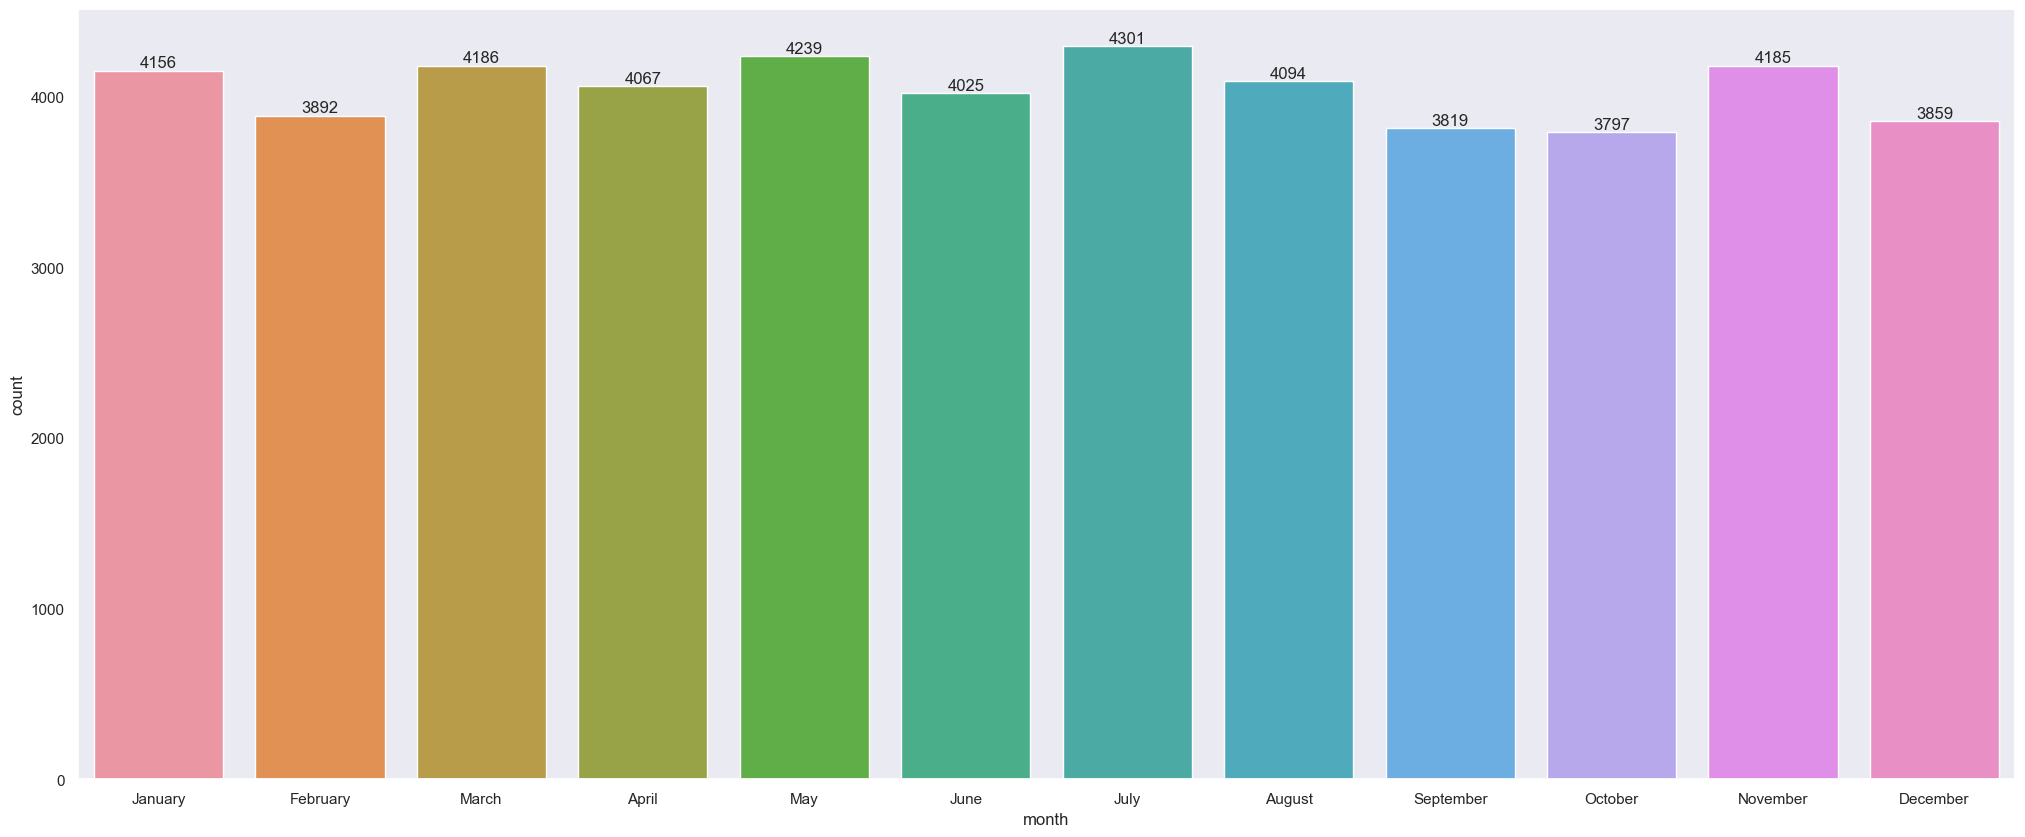

In [102]:
plt.figure(figsize = (25,10))
sns.set_theme(style="dark")
ax = sns.countplot(x = 'month',data = df)
for container in ax.containers:
    ax.bar_label(container)


### 13. Demand forecasting based on order date and the no.of pizza sold

In [103]:
df_order_qty= df.groupby(['order_date'])['quantity'].sum().reset_index()

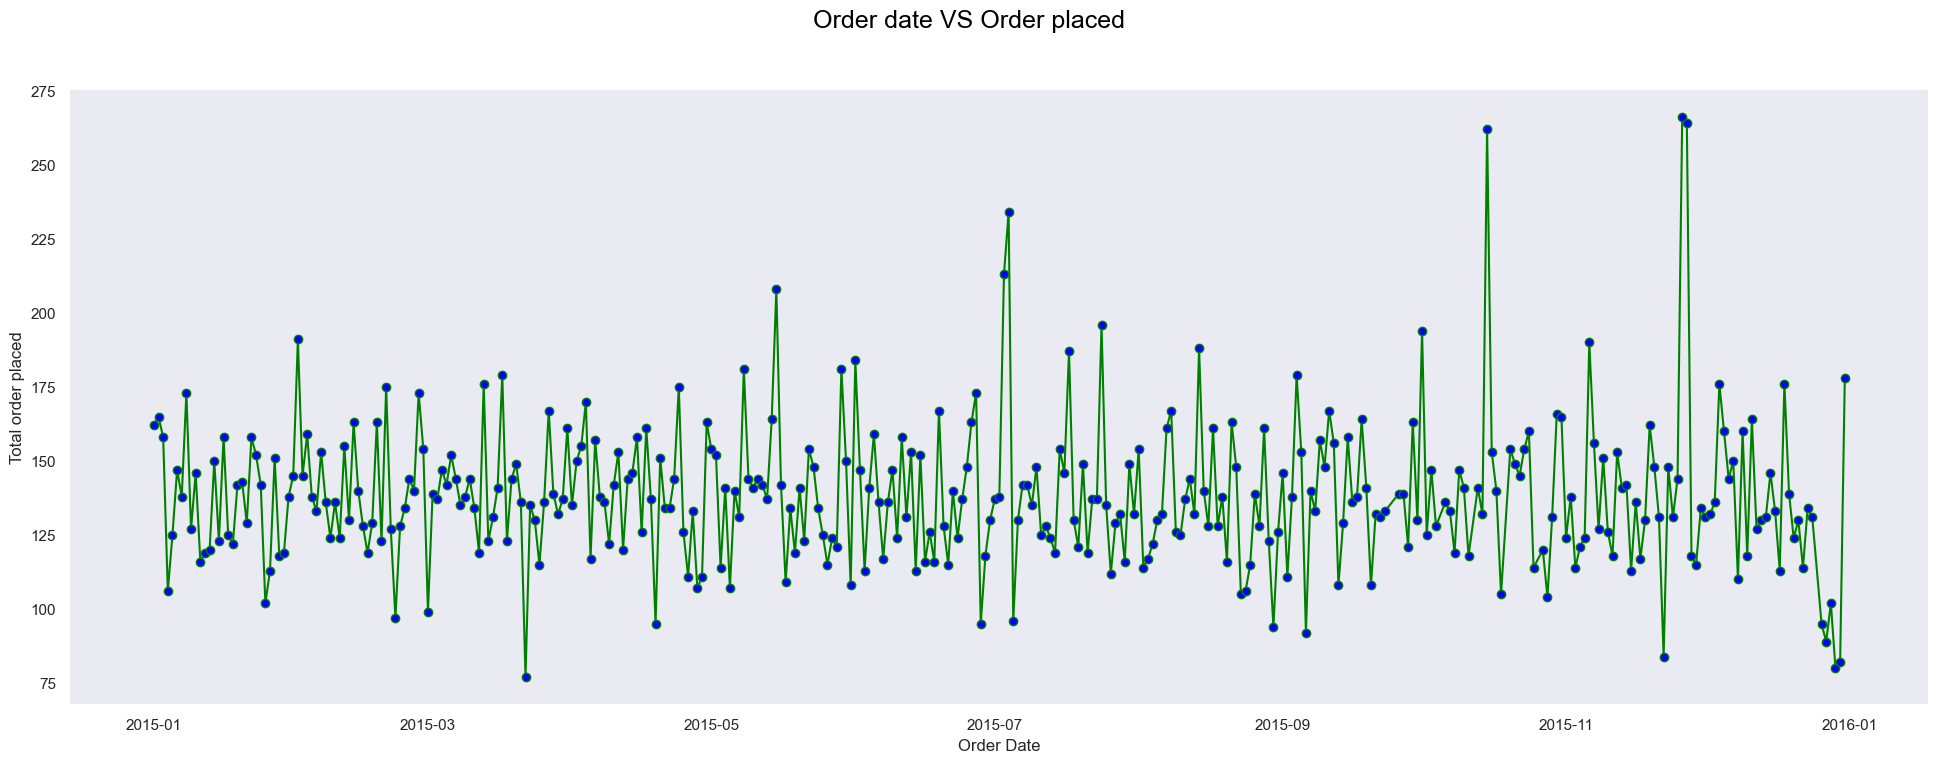

In [104]:
plt.figure(figsize=(24,8))
plt.suptitle('Order date VS Order placed', fontsize=18, color='black')
plt.plot(df_order_qty.order_date, df_order_qty.quantity, marker='o', markerfacecolor='blue',markersize=6, color='green')
plt.xlabel('Order Date')
plt.ylabel('Total order placed')
plt.show() 

### Introducing ARIMA time series model to forecast.

In [105]:
#importing ARIMA lib
from statsmodels.tsa.arima.model import ARIMA

In [106]:
#creating the model for quantity
model = ARIMA(df_order_qty['quantity'], order=(1,1,0))
model_fit = model.fit()
#Forecast prediction
df_order_qty['forecast'] = model_fit.predict()

#### Below plot depicts the demand forecast 

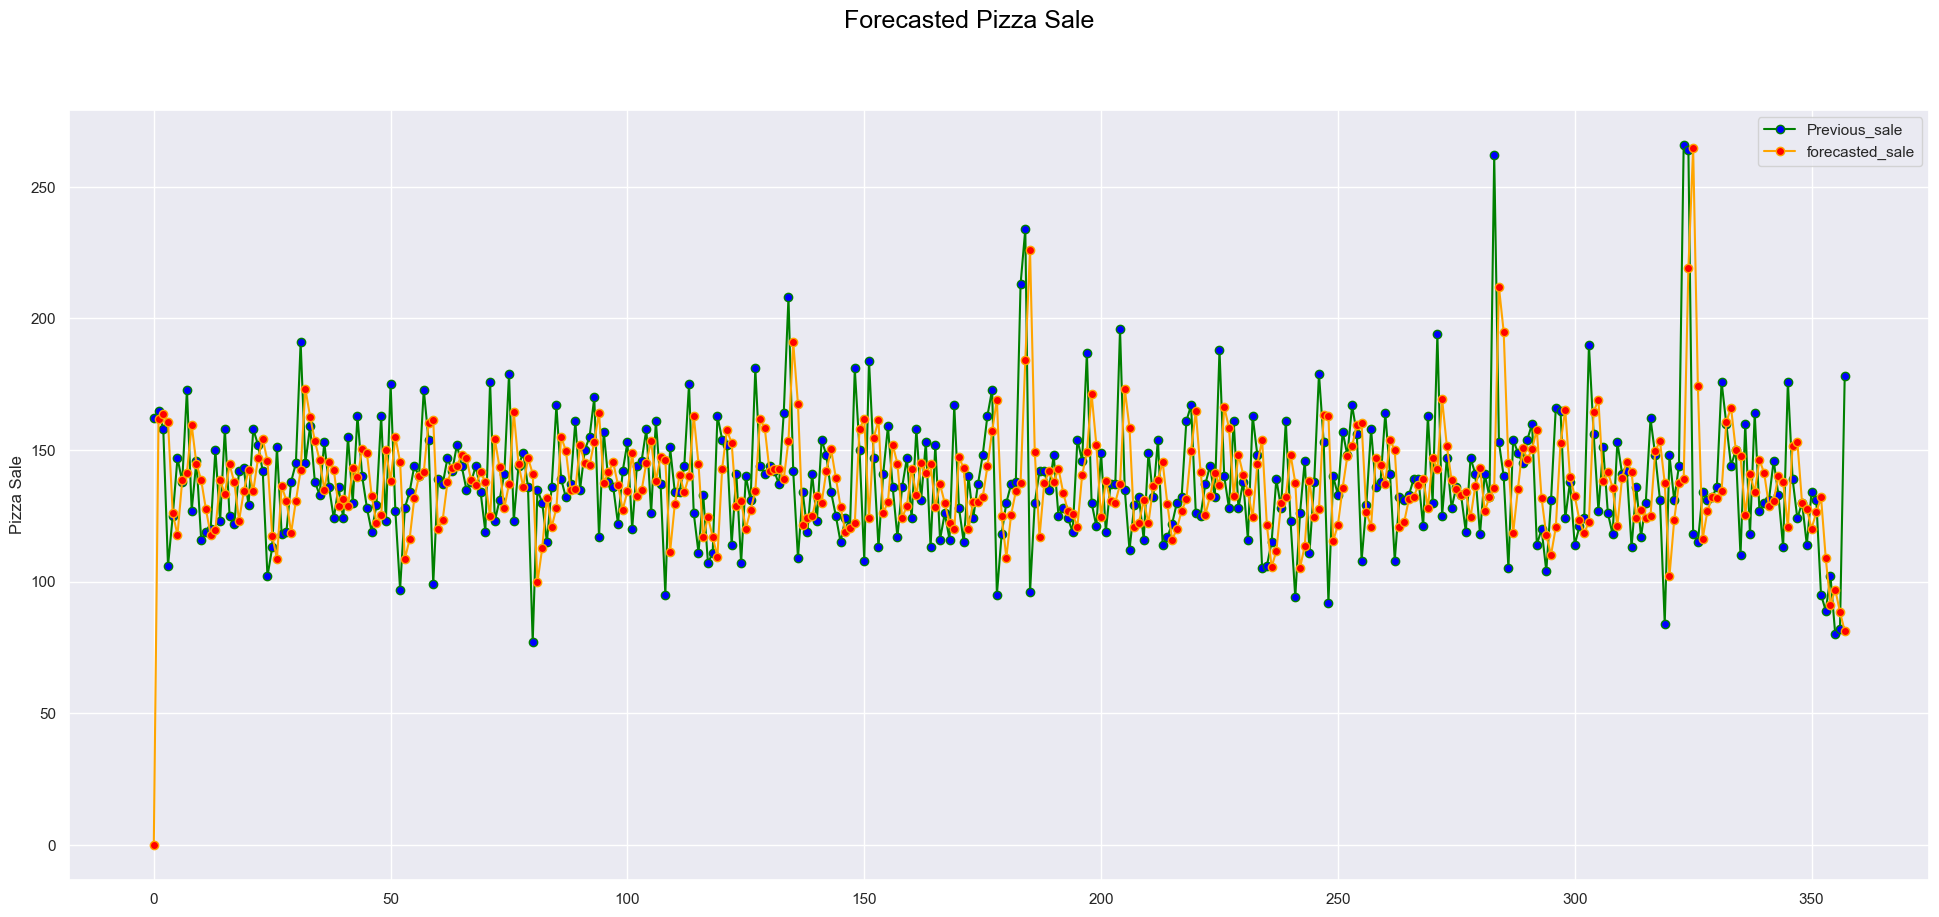

In [107]:
plt.figure(figsize=(24,10))
plt.suptitle('Forecasted Pizza Sale', fontsize=18, color='black')
plt.plot(df_order_qty.quantity, marker='o', markerfacecolor='blue',markersize=6, color='green',label="Previous_sale")
plt.plot( df_order_qty.forecast, marker='o', markerfacecolor='red',markersize=6, color='orange',label="forecasted_sale")
plt.ylabel('Pizza Sale')
plt.legend()
plt.grid()
plt.show() 